<a href="https://colab.research.google.com/github/Mors666/hopfieldRNN/blob/master/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np
from sympy import KroneckerDelta as kron
import matplotlib.pyplot as plt
#import pydot
import time
import random
from multiprocessing import Process, Queue,set_start_method

In [0]:
try: # otherwise it complains: context has already been set
  set_start_method("spawn")
except: pass

In [0]:
n = torch.LongTensor([70]) #общее число работников в организации

C = np.random.randint(0, 11, (n, n)) #затраты ребер графа
C = np.tril(C) + np.tril(C, -1).T #матрица затрат должна быть симметричной
np.fill_diagonal(C, 0, wrap=False)

P = np.random.randint(0, 2, (n, n)) #несуществующие ребра графа
P = np.tril(P) + np.tril(P, -1).T
#P = (P + P.T)/2
np.fill_diagonal(P, 1, wrap=False) 

for i in range(n):
    for j in range(n):
        if P[i][j] == 1:
            C[i][j] = 10

'''print('матрица затрат')
print(C)
print(P)'''

C = torch.from_numpy(C) 
P = torch.from_numpy(P) 

In [0]:
mu1 =torch.FloatTensor([950.]) #3000
mu2 = torch.FloatTensor([475.]) #480
mu3 = torch.FloatTensor([1500.]) #50000
mu4 = torch.FloatTensor([2500.]) #15000
mu5 = torch.FloatTensor([2500.]) #50000

In [543]:
A = torch.FloatTensor([0.0001])  
B = torch.FloatTensor([0.00001]) 
D = torch.FloatTensor([0.00001]) 

ex_number = np.around(n.mul(2/3), decimals=0) # 2/3 - кол-во исполнителей относительно общего числа работников
director = 0 #номер узла, соответствующего топ-менеджеру в иерархии
executors = random.sample(range(1,n), int(ex_number)) #случайно выбранные индексы исполнителей  
print(executors)

[45, 16, 22, 36, 56, 63, 41, 1, 57, 46, 6, 61, 18, 30, 3, 31, 50, 29, 67, 58, 54, 60, 62, 21, 47, 12, 64, 24, 23, 10, 13, 20, 43, 28, 4, 49, 25, 17, 66, 39, 8, 7, 53, 38, 37, 11, 65]


In [0]:
def init_weights():
    start = time.time()
      
    for x in range(n):
        for i in range(n):
            for y in range(n):
                for j in range(n):
                 
                    weights[x*n+i,y*n+j] = mu2*torch.tensor(kron(x, y)*kron(i, j),dtype=torch.float64) - mu4*torch.tensor(kron(x, y),dtype=torch.float64) - mu4*torch.tensor(kron(i, j),dtype=torch.float64) + mu4*torch.tensor(kron(j, x),dtype=torch.float64) + mu4*torch.tensor(kron(i, y),dtype=torch.float64)
    
    finish = time.time()
    result = finish - start
    print("Время на инициализацию матрицы весов: " + str(result) + " секунд")
    return weights
    '''start = time.time()
     
      
    for x in range(n):
        for i in range(n):
            for y in range(n):
                for j in range(n):
                    if x==y==i==j:
                        weights[n*x+i,n*y+j] = mu2
                    elif x==y and i==j and j!=x:
                        weights[n*x+i,n*y+j] = mu2.sub(mu4.sub(mu4))  
                    elif (x==y and i!=j and (j==x or i==y)) or (x!=y!=i!=j) or (x!=y and i==j and (j==x or i==y)):
                        weights[n*x+i,n*y+j] = 0.
                    elif x!=y and i!=j and j==x and i==y:
                        weights[n*x+i,n*y+j] =  mu4.add(mu4)  
                    elif x!=y and i!=j and (j==x or i==y):    
                        weights[n*x+i,n*y+j] = mu4
                    elif (x==y or i==j) and j!=x and i!=y:
                        weights[n*x+i,n*y+j] = -mu4
                     
                    #weights[n*x+i,n*y+j] = mu2.mul(torch.FloatTensor([kron(x, y)*kron(i, j)]).cuda()) - mu4.mul(torch.FloatTensor([kron(x, y)]).cuda()) - mu4.mul(torch.FloatTensor([kron(i, j)]).cuda()) + mu4.mul(torch.FloatTensor([kron(j, x)]).cuda()) + mu4.mul(torch.FloatTensor([kron(i, y)]).cuda())
                    #mu2*kron(x, y)*kron(i, j) - mu4*kron(x, y) - mu4*kron(i, j) + mu4*kron(j, x) + mu4*kron(i, y)
    
    finish = time.time()
    result = finish - start
    print("Время на инициализацию матрицы весов: " + str(result) + " секунд")
    return weights'''

In [0]:
def energy(m,OUT, ftype):
    #OUT = K.reshape(OUT, (n,n))
    #ftype = ftype + OUT
    OUT = OUT.resize_((n,n)) 
    E1 = torch.FloatTensor([0]) 
    E2 = torch.FloatTensor([0]) 
    E3 = torch.FloatTensor([0]) 
    E4 = torch.FloatTensor([0]) 
    E5 = torch.FloatTensor([0]) 
    
    for x in range(n):
        for i in range(n):
            if (i != x) and (x!=m and i!=director):
                E1 = E1.add(torch.mul(C[x][i], torch.mul(torch.div(1,torch.add(1,ftype[x][i])),OUT[x][i]))) 
                #E1 + C[x][i]*(1/(1+ftype[x][i]))*OUT[x][i]  
                E3 = E3.add(torch.mul(P[x][i],OUT[x][i]))
                #E3+P[x][i]*OUT[x][i]
            if i != x:
                E2 =  E2.add(torch.mul(OUT[x][i],torch.sub(1,OUT[x][i])))
                #E2 + OUT[x][i]*(1-OUT[x][i])
                 
                
    out1=torch.FloatTensor([0]) 
    out2=torch.FloatTensor([0]) 
    #square=0
    for x in range(n):
        for i in range(n):
            if i != x:
                out1 = out1.add(OUT[x][i])
                #out1+OUT[x][i]
                out2 = out1.add(OUT[i][x])
                #out2+OUT[i][x]
        #square = (out1-out2)*(out1-out2)
        E4 = E4.add(torch.mul(out1.sub(out2),out1.sub(out2)))
        #E4 + (out1-out2)*(out1-out2)
        
    E5 = torch.sub(1,OUT[m][director])
    #1-OUT[m][director]
    
    E =  torch.add(mu1.mul(E1),mu2.mul(E2))
    E = E.add(mu3.mul(E3))
    E = E.add(mu4.mul(E4))
    E = E.add(mu5.mul(E5))
    #torch.add(mu1.mul(E1),torch.add(mu2.mul(E2),torch.add(mu3.mul(E3),torch.add(mu4.mul(E4),torch.add(mu5.mul(E5)))))) 
    #mu1*E1 + mu2*E2 + mu3*E3 + mu4*E4 + mu5*E5
    
    #OUT = K.reshape(OUT, (n*n,1))
    OUT = OUT.resize_((n*n,1))
    return E

In [0]:
def bias_init(ftype,m): #инициализатор смещения нейронов (bias)
    bias = torch.zeros((n*n,1)) 
    idx = 0 
    for x in range (n):
        for i in range (n):
             
            if (x==m and i==director):
                bias[idx] = mu5/2-mu2/2
            else:
                bias[idx] = -mu1/2*C[x][i]*ftype[x][i]-mu3/2*P[x][i]-mu2/2 
            idx = idx + 1;
        #bias=np.concatenate(bias)
    #bias = torch.stack(bias)
    '''b = torch.zeros((n*n,1)).cuda() #np.zeros((n*n,1))
 
    for x in range (n*n):
        b[x][0]= bias[x]
        #b = b.shape((n*n,1))'''
    #print(bias)
    return bias

In [0]:
def input_tensor():  
        IN = np.full((n,n), 0.5 + np.random.uniform(-0.00001, 0.00001, (n,n)))  # 0.00001 
        IN.shape = (n*n,1)
        #IN= torch.from_numpy(IN) 
        inp = torch.tensor(IN,dtype=torch.float64)
        return inp

In [0]:
#torch.set_printoptions(precision=10)
#print(input_tensor())

In [0]:
class RNN(torch.nn.RNNCell):
    def __init__(self, input_size, IN,weights, bias, nonlinearity):
        super(RNN, self).__init__(input_size, hidden_size=input_size, bias=False)
        self.input_size = self.hidden_size = input_size
        self.bias = True
        self.nonlinearity = nonlinearity
        self.prev_in = [] #входные значения с предыдущих итераций
        self.energies = [] #значения функции энергии
        self.prev_energy = torch.tensor([1e10]).float() #np.Infinity #значение энергии на предыдущей итерации
        self.worker = -1 #номер узла исполнителя, для которого используется сеть
        self.stop = False #для остановки в случае увеличения энергии
        self.result = IN#.share_memory_() #выходной сигнал после определенной итерации
        self.weight_ih = self.weight_hh = weights
        #print(self.weight_ih)
        self.bias_ih = self.bias_hh = bias
        #print(self.bias_ih)
        #self.threshold = torch.nn.Threshold(0.5,0)

    def calc_thresholds(self, out):
        #threshold = torch.nn.Threshold(0.5,0)
        #out = threshold(out).float()
        one = torch.tensor([1.0]).float()
        zero = torch.tensor([0.0]).float()
   
        return torch.where(out>0.5,one,zero)

    def forward(self, input, hx=None):
        activation = torch.nn.Sigmoid()
        '''print(self.weight_ih.shape)
        print(input.shape)
        print(self.bias_ih.shape)'''
        #input = input.resize_((1, n*n))
        hx = torch.add(torch.mm(self.weight_ih.float(),input.float()), self.bias_ih)  #torch.add(, self.bias_ih)
        hx = activation(hx)
        inputs = hx
        if len(self.prev_in) ==1:
            inputs = self.prev_in[0] + D*hx
             
        elif len(self.prev_in) ==2:
            inputs =  self.prev_in[1] - A*self.prev_in[0] + D*hx
            
        elif len(self.prev_in) > 2:
            inputs = self.prev_in[len(self.prev_in)-1] - A*self.prev_in[len(self.prev_in)-2] - B*self.prev_in[len(self.prev_in)-3]+ D*hx
             
        self.prev_in.append(inputs)

        return  inputs

In [550]:
weights = torch.zeros((n*n,n*n))  
W = torch.nn.Parameter(init_weights(), requires_grad=False)
#print(W)

Время на инициализацию матрицы весов: 2742.745715379715 секунд


In [0]:
ftype = torch.zeros((n,n))
#m=0
#print(bias_init(ftype,m))

In [0]:
def create_RNN(m):
    mRNN = RNN(n*n,IN= input_tensor(),
                 weights = W , 
                 bias = torch.nn.Parameter(bias_init(ftype,m), requires_grad=False),
                 nonlinearity = "sigmoid")
    mRNN.worker = m
    return mRNN

In [0]:
def one_iteration(HNN):#i,q):
    #print("in one_iteration")
    #mRNN.bias = bias_init(ftype,mRNN.worker)
    output = HNN.forward(HNN.result)
    curr_energy = energy(HNN.worker,output,ftype)
        #print(curr_energy)
    HNN.prev_in.append(output)
    if torch.lt(torch.sub(HNN.prev_energy,curr_energy),torch.tensor([1e-5])):
        print("previous energy:")
        print(HNN.prev_energy)
        print("current energy:")
        print(curr_energy)
      
        HNN.stop = True
        HNN.result = output#mRNN.prev_in[len(mRNN.prev_in)-2]
        HNN.energies.append(curr_energy)
    else:
        #print("in else")
        HNN.prev_energy = curr_energy
        HNN.energies.append(HNN.prev_energy)
        HNN.result = output
        HNN.bias = bias_init(ftype,HNN.worker)
    #print("before q.put")
    #q.put([all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop,all_RNN[i].prev_in,all_RNN[i].energies])
    #q.put(all_RNN[i].result)

In [0]:
ftype = torch.zeros((n,n))

In [555]:
torch.set_printoptions(precision=8,profile="full")
'''mRNN = create_RNN(2)
mRNN.result = mRNN.forward(mRNN.result)
print(energy(2,mRNN.result,ftype))'''

'mRNN = create_RNN(2)\nmRNN.result = mRNN.forward(mRNN.result)\nprint(energy(2,mRNN.result,ftype))'

In [556]:
'''mRNN.bias = bias_init(ftype,mRNN.worker)
mRNN.result = mRNN.forward(mRNN.result)
print(energy(2,mRNN.result,ftype))'''

'mRNN.bias = bias_init(ftype,mRNN.worker)\nmRNN.result = mRNN.forward(mRNN.result)\nprint(energy(2,mRNN.result,ftype))'

In [557]:
'''torch.set_printoptions(precision=8,profile="full")
mRNN = create_RNN(1)
#mRNN.result = mRNN.forward(mRNN.result)
output = mRNN.forward(mRNN.result)
print(output)
curr_energy = energy(1,output,ftype)
print(curr_energy)
mRNN.prev_in.append(output)
mRNN.bias = bias_init(ftype,mRNN.worker)'''

'torch.set_printoptions(precision=8,profile="full")\nmRNN = create_RNN(1)\n#mRNN.result = mRNN.forward(mRNN.result)\noutput = mRNN.forward(mRNN.result)\nprint(output)\ncurr_energy = energy(1,output,ftype)\nprint(curr_energy)\nmRNN.prev_in.append(output)\nmRNN.bias = bias_init(ftype,mRNN.worker)'

In [558]:
#print(energy(0,mRNN.result,ftype))
'''mRNN.result = output
output = mRNN.forward(mRNN.result)
print(output)
curr_energy = energy(1,output,ftype)
print(curr_energy)'''

'mRNN.result = output\noutput = mRNN.forward(mRNN.result)\nprint(output)\ncurr_energy = energy(1,output,ftype)\nprint(curr_energy)'

In [0]:
#print(mRNN.calc_thresholds(mRNN.result))

In [560]:
'''mRNN.result = mRNN.forward(mRNN.result)
mRNN.bias = bias_init(ftype,mRNN.worker)'''
#print(mRNN.result)

'mRNN.result = mRNN.forward(mRNN.result)\nmRNN.bias = bias_init(ftype,mRNN.worker)'

In [0]:
#print(energy(0,mRNN.result,ftype))

In [0]:
all_start = time.time()

In [563]:
if __name__ == '__main__':
    all_RNN=[]
    #ftype = torch.zeros((n,n))
    for m in executors:
        '''mRNN = RNN(n*n,IN= input_tensor(),
                  weights = W , 
                  bias = torch.nn.Parameter(bias_init(ftype,m), requires_grad=False),
                  nonlinearity = "sigmoid")
        mRNN.worker = m'''
        #mRNN = create_RNN(m)#.share_memory()
            #mRNN.result.share_memory_()
        all_RNN.append(create_RNN(m))
        #print(all_RNN[0].stop)
    
    #print("initial result")
    #print(all_RNN[0].result)
    iterat = 0
    for mRNN in all_RNN:
        mRNN.forward(mRNN.result) 
    while not all(mRNN.stop == True for mRNN in all_RNN) and iterat<10:
        #print(all_RNN[0].stop)
        print("ITERATION " + str(iterat))
        #if iterat>0:
            #for i in range(len(executors)):
             #   ftype = ftype + all_RNN[i].result.resize_((n,n))
              #  all_RNN[i].result = all_RNN[i].result.resize_((n*n,1))
        iterat = iterat + 1

        #for i in range(len(executors)):
        for mRNN in all_RNN:
            if mRNN.stop == False:
                one_iteration(mRNN)

        #print(all_RNN[0].result)
        ftype = torch.zeros((n,n))

    '''for mRNN in all_RNN:
        OUT = mRNN.result#all_RNN[i].calc_thresholds(all_RNN[i].result)
        OUT.resize_((n,n))
        print("Результаты для исполнителя "+str(mRNN.worker)+":") 
        print(OUT)'''
     

ITERATION 0
ITERATION 1
ITERATION 2
ITERATION 3
ITERATION 4
ITERATION 5
ITERATION 6
ITERATION 7
ITERATION 8
ITERATION 9


energy values
6261799.0
6261253.5
6260792.0
6260389.0
6259918.0
6259383.0
6258840.0
6258367.5
6257988.5
6257500.5


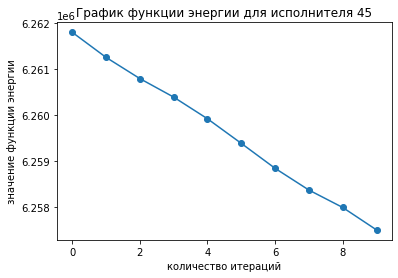

energy values
6204113.0
6203579.5
6203134.5
6202747.5
6202309.0
6201771.0
6201235.5
6200776.0
6200406.0
6199957.5


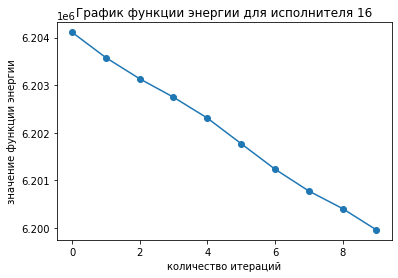

energy values
6226994.0
6226465.0
6226012.5
6225635.0
6225174.5
6224644.5
6224111.5
6223649.5
6223282.5
6222824.5


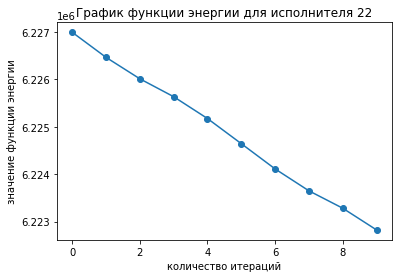

energy values
6244982.0
6244440.0
6243995.0
6243581.5
6243139.5
6242598.0
6242044.0
6241594.5
6241221.0
6240741.5


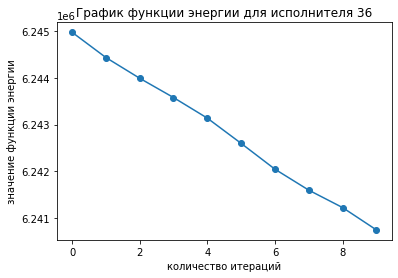

energy values
6244835.5
6244307.5
6243852.0
6243449.0
6242998.0
6242466.5
6241925.5
6241474.0
6241087.5
6240624.0


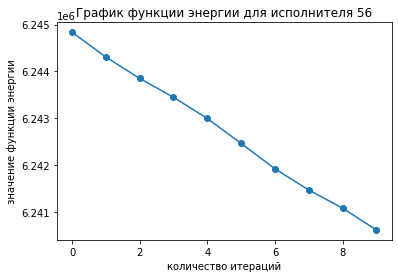

energy values
6187463.0
6186951.5
6186488.5
6186108.5
6185669.0
6185137.5
6184619.5
6184159.5
6183802.0
6183337.5


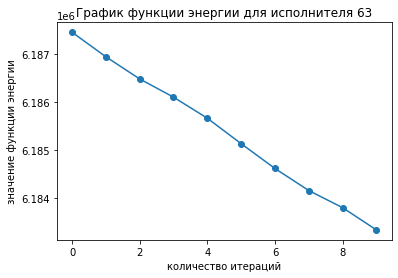

energy values
6232355.0
6231834.0
6231374.5
6230949.0
6230494.5
6229960.0
6229434.0
6228973.0
6228571.5
6228100.0


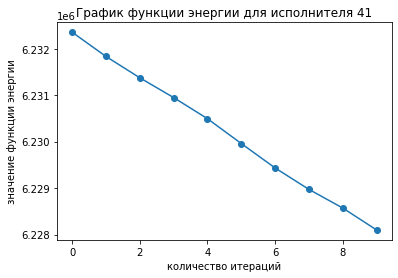

energy values
6240633.5
6240096.5
6239638.5
6239229.5
6238784.0
6238243.0
6237696.0
6237230.5
6236851.0
6236375.0


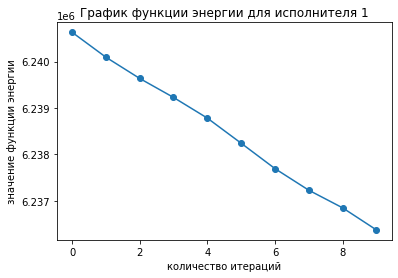

energy values
6253309.5
6252778.0
6252323.0
6251897.0
6251448.0
6250916.0
6250376.0
6249915.5
6249526.0
6249047.0


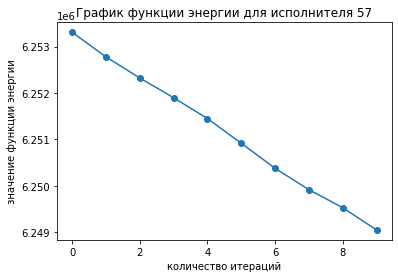

energy values
6232097.5
6231580.5
6231131.5
6230692.0
6230252.0
6229714.5
6229187.0
6228736.0
6228335.0
6227878.5


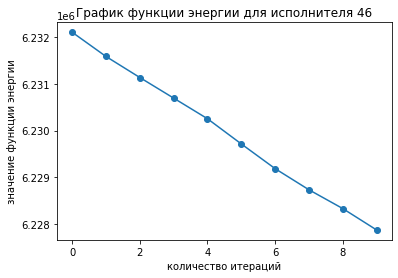

energy values
6232540.5
6232018.5
6231558.5
6231160.5
6230710.5
6230170.5
6229633.5
6229175.0
6228802.0
6228343.0


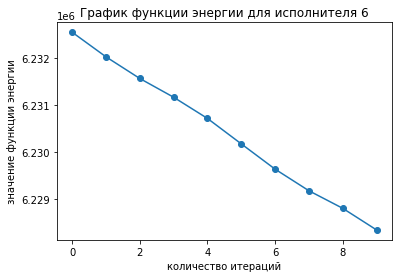

energy values
6254371.0
6253843.0
6253390.0
6252988.0
6252537.0
6251993.0
6251441.5
6250986.0
6250625.5
6250153.5


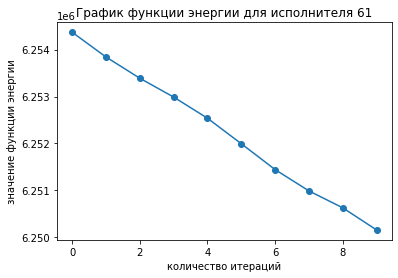

energy values
6260942.5
6260410.0
6259948.5
6259543.0
6259088.5
6258545.0
6258011.5
6257536.5
6257167.5
6256688.0


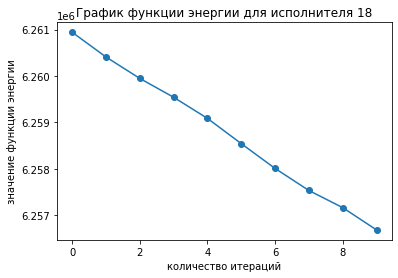

energy values
6208067.5
6207537.5
6207081.5
6206714.0
6206258.5
6205730.5
6205206.5
6204729.0
6204390.0
6203914.5


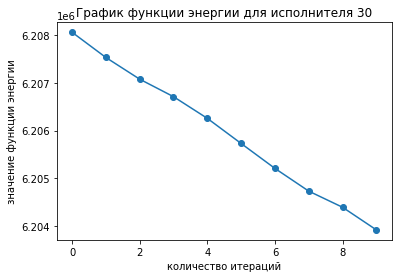

energy values
6226439.0
6225903.0
6225464.0
6225071.5
6224614.5
6224082.5
6223554.5
6223090.0
6222726.0
6222263.0


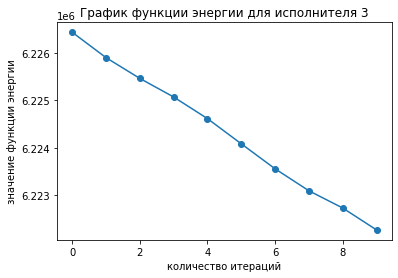

energy values
6215367.0
6214859.5
6214399.5
6214024.5
6213580.5
6213041.5
6212520.5
6212054.5
6211711.0
6211246.5


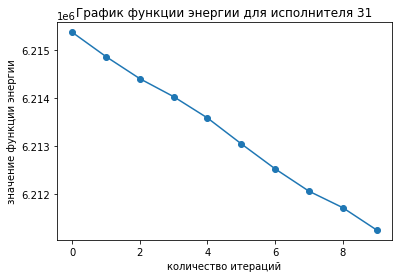

energy values
6244730.5
6244192.0
6243751.0
6243349.5
6242912.5
6242363.5
6241822.0
6241373.0
6240990.5
6240539.0


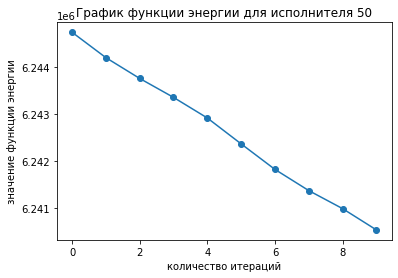

energy values
6229508.5
6228971.5
6228532.0
6228118.5
6227681.5
6227141.5
6226603.5
6226156.5
6225783.5
6225318.0


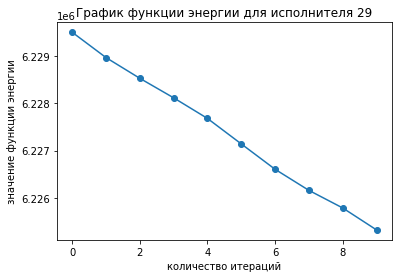

energy values
6223973.5
6223450.5
6222984.0
6222591.0
6222127.0
6221603.0
6221071.0
6220606.0
6220246.0
6219769.5


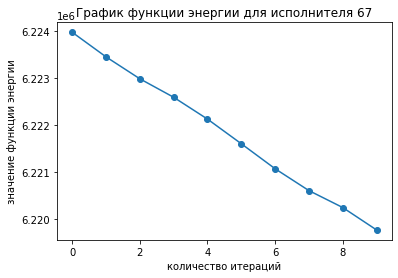

energy values
6233085.0
6232545.5
6232095.0
6231705.0
6231274.5
6230721.0
6230198.5
6229738.5
6229370.0
6228900.5


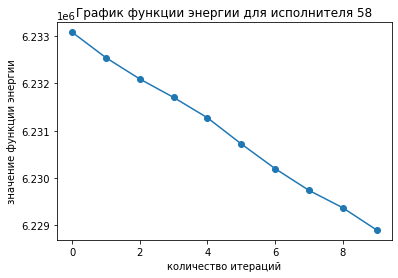

energy values
6215350.0
6214827.0
6214374.0
6213995.5
6213544.0
6213013.0
6212477.5
6212020.5
6211675.5
6211201.0


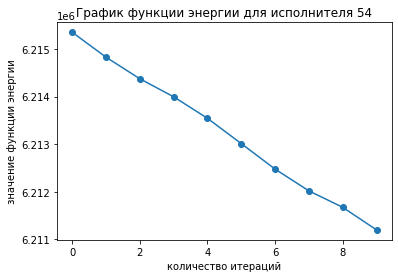

energy values
6227679.5
6227158.5
6226692.5
6226315.0
6225845.0
6225312.5
6224776.5
6224289.5
6223955.0
6223469.0


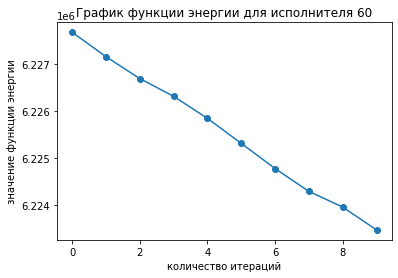

energy values
6228775.5
6228240.5
6227777.5
6227414.5
6226950.0
6226413.0
6225882.0
6225405.0
6225072.5
6224587.0


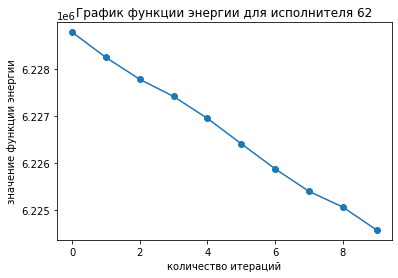

energy values
6180071.0
6179566.0
6179111.0
6178713.0
6178266.0
6177745.0
6177225.5
6176767.5
6176398.0
6175926.5


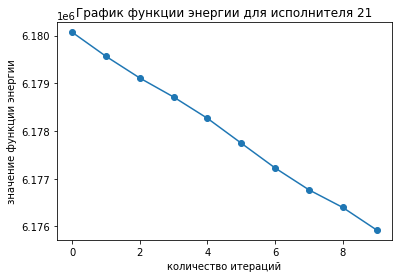

energy values
6214876.5
6214334.0
6213895.0
6213512.0
6213069.0
6212528.5
6211987.5
6211539.0
6211168.5
6210719.0


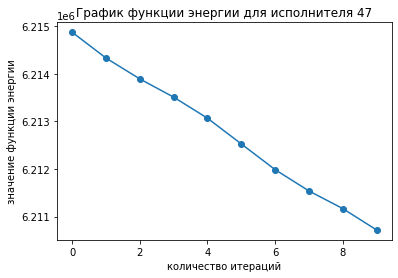

energy values
6244662.5
6244132.5
6243669.0
6243291.5
6242839.5
6242302.0
6241763.0
6241293.5
6240934.0
6240472.0


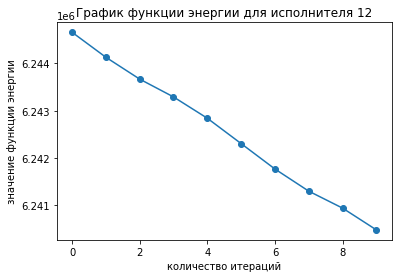

energy values
6224030.5
6223500.5
6223050.0
6222644.0
6222204.0
6221653.5
6221125.0
6220675.5
6220285.0
6219816.0


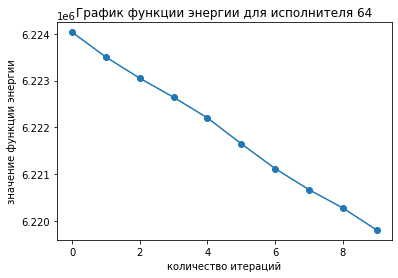

energy values
6229193.5
6228663.5
6228206.5
6227796.0
6227336.5
6226813.5
6226274.5
6225807.5
6225433.0
6224954.0


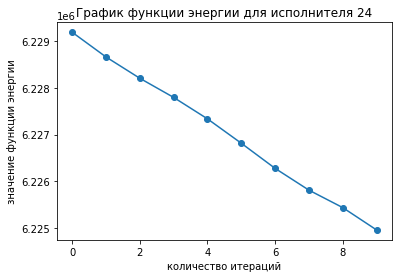

energy values
6191830.5
6191296.5
6190871.5
6190453.0
6190006.0
6189488.5
6188971.5
6188522.0
6188132.5
6187671.0


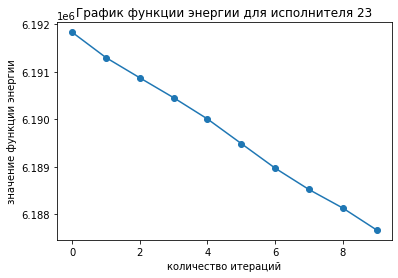

energy values
6263984.0
6263439.5
6262969.5
6262583.0
6262117.0
6261575.5
6261022.5
6260547.0
6260177.0
6259700.5


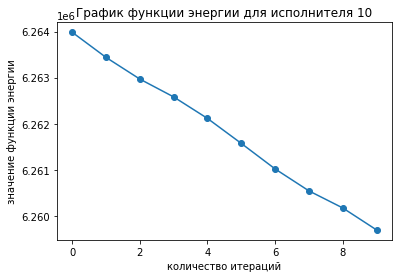

energy values
6224492.5
6223950.5
6223499.0
6223119.5
6222681.0
6222127.5
6221587.0
6221127.0
6220770.0
6220311.5


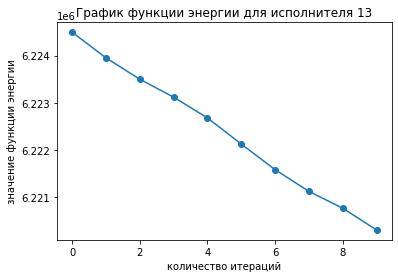

energy values
6237171.0
6236639.5
6236175.0
6235806.0
6235340.5
6234802.5
6234265.5
6233787.0
6233425.5
6232970.5


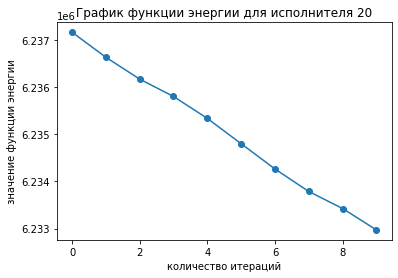

energy values
6230216.5
6229702.0
6229239.0
6228850.0
6228389.0
6227853.5
6227324.5
6226863.0
6226494.0
6226022.5


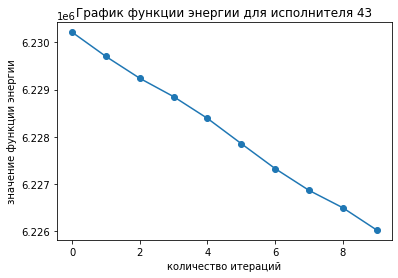

energy values
6220460.5
6219939.0
6219486.0
6219078.5
6218644.0
6218118.5
6217588.5
6217130.0
6216745.5
6216288.5


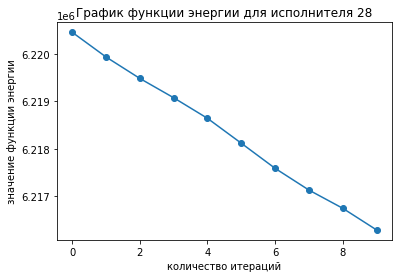

energy values
6250578.5
6250052.0
6249593.0
6249201.0
6248746.0
6248206.0
6247667.5
6247204.0
6246836.5
6246370.5


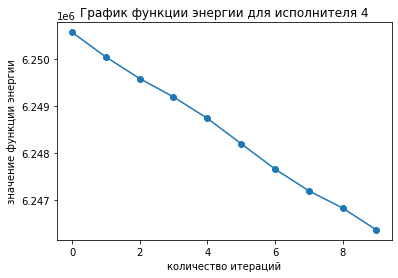

energy values
6250430.0
6249895.0
6249442.5
6249041.0
6248587.5
6248047.0
6247511.0
6247045.5
6246669.5
6246195.0


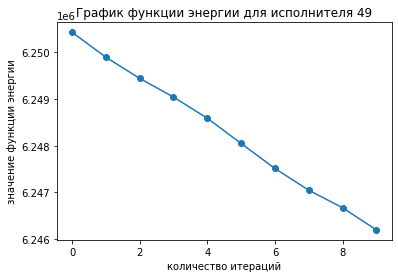

energy values
6263182.5
6262631.0
6262168.5
6261804.0
6261329.5
6260773.5
6260227.0
6259752.0
6259403.5
6258914.5


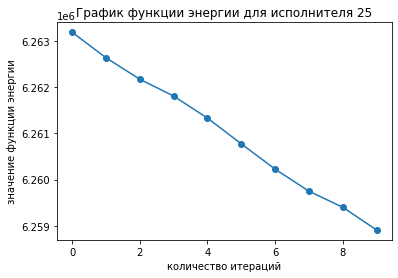

energy values
6258398.5
6257864.0
6257403.0
6257009.0
6256552.5
6256003.5
6255458.0
6255000.0
6254618.0
6254152.0


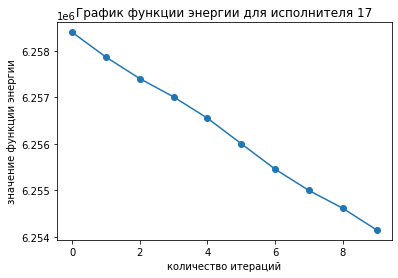

energy values
6206762.0
6206232.0
6205786.0
6205403.0
6204962.0
6204420.0
6203881.5
6203419.5
6203073.5
6202613.5


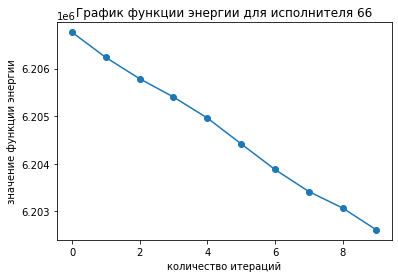

energy values
6232199.5
6231664.0
6231210.5
6230825.0
6230370.0
6229838.5
6229298.5
6228824.0
6228479.0
6228003.0


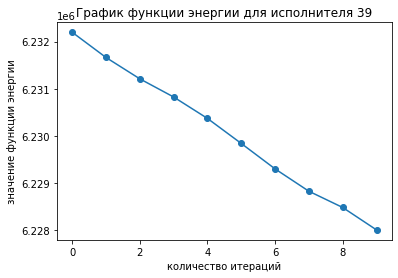

energy values
6232738.5
6232207.0
6231743.5
6231361.5
6230901.0
6230373.5
6229825.0
6229368.0
6229011.0
6228527.0


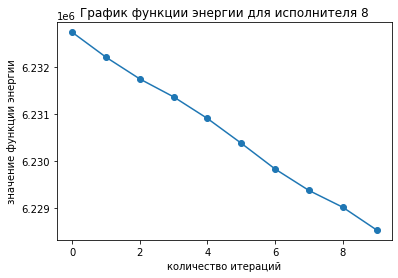

energy values
6254394.0
6253857.0
6253384.5
6253008.5
6252553.5
6252008.5
6251476.0
6250990.0
6250650.0
6250163.5


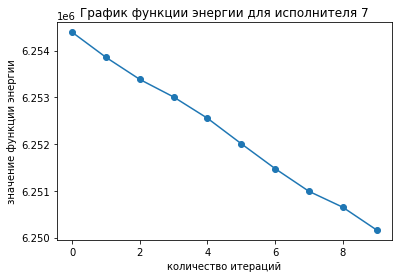

energy values
6236558.5
6236043.5
6235570.0
6235169.0
6234720.0
6234184.0
6233643.5
6233183.5
6232810.0
6232330.0


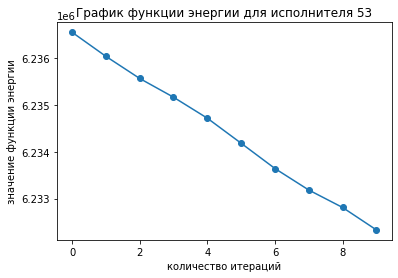

energy values
6225520.5
6224994.0
6224556.5
6224144.5
6223707.0
6223181.0
6222639.5
6222199.5
6221818.5
6221362.0


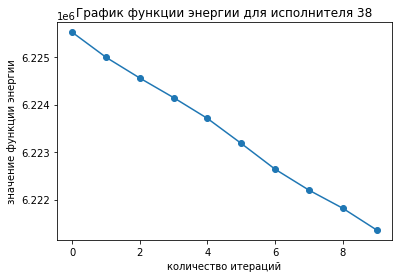

energy values
6261611.5
6261063.0
6260608.0
6260194.5
6259738.0
6259191.0
6258637.0
6258181.0
6257782.0
6257308.5


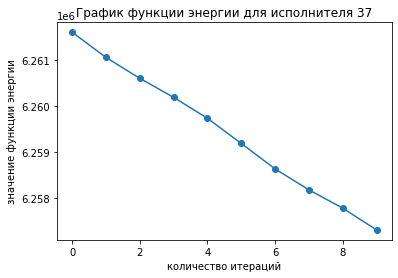

energy values
6249722.0
6249193.5
6248739.5
6248319.5
6247865.0
6247330.5
6246798.0
6246327.5
6245935.0
6245468.0


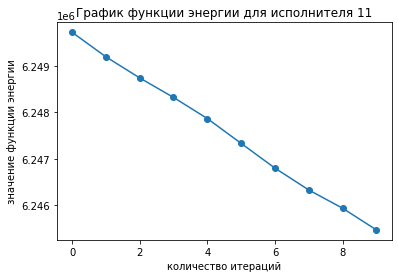

energy values
6228256.5
6227724.5
6227258.5
6226887.0
6226415.5
6225883.5
6225340.5
6224878.0
6224518.5
6224049.5


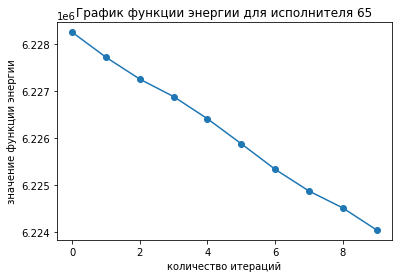

In [564]:
for mRNN in  all_RNN:
    iterations = np.arange(0,len(mRNN.energies))
#print(iterations)
#print(len(energies))
    e =  np.zeros((len(mRNN.energies),))
#print(e)
    print("energy values")
    for i in range(len(mRNN.energies)):
        e[i] = mRNN.energies[i]
         
        print(e[i])
    #print(K.eval(energies[i]))
#j=0
#for i in range(0,len(mRNN.energies),10):
    #energy[j] = K.eval(mRNN.energies[i])
    #j=j+1
        
    plt.plot(iterations,e, marker='o')
    plt.title("График функции энергии для исполнителя "+str(mRNN.worker))
    plt.xlabel("количество итераций")
    plt.ylabel("значение функции энергии")
    plt.show()

In [565]:
for i in range(len(executors)):
        #for mRNN in all_RNN:
    print(all_RNN[i].stop)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [566]:
'''if __name__ == '__main__':
    #set_start_method('spawn')
    all_RNN=[]
    for m in executors:
        mRNN = create_RNN(m)#.share_memory()
        #mRNN.result.share_memory_()
        all_RNN.append(mRNN)
    print(all_RNN[0].result)
    iterat = 0
    while not all(mRNN.stop == True for mRNN in all_RNN) and iterat<10:
        #mRNN.share_memory()
        print(iterat)
        #print(iterat)
        if iterat>0:
            for i in range(len(executors)):
                ftype = ftype + all_RNN[i].result.resize_((n,n))
        iterat = iterat + 1
        #param = np.Infinity
        queues = []
        #queue = Queue()
        procs = []

        for i in range(len(executors)):
            if (all_RNN[i].stop == False):
                queue = Queue()
                queues.append(queue)
                p = Process(target=one_iteration, args=(i,queue,))
                procs.append(p)
                print("process"+str(len(procs)))     
                p.start()
             
        j=0
         
        for i in range(len(executors)):
             
            if (all_RNN[i].stop == False) :
                 
                #print(queues[j].get())
                #[all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop,all_RNN[i].prev_in,all_RNN[i].energies] = queues[j].get()
                #all_RNN[i].result = queues[j].get()
                j = j+1
                    
                #[all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop] = queue.get()
                #all_RNN[i].energies.append(all_RNN[i].prev_energy)
            
        for proc in procs:
            proc.join()
            #print("process joined") 
        j=0
        for i in range(len(executors)):
             
            if (all_RNN[i].stop == False) :
                 
                print(queues[j].get())
                j = j+1 
            #ftype = ftype + K.eval(all_RNN[i].result).reshape(n,n)
            #print(ftype)
            
        ftype = torch.zeros((n,n)) 
    print(all_RNN[0].result)'''

'if __name__ == \'__main__\':\n    #set_start_method(\'spawn\')\n    all_RNN=[]\n    for m in executors:\n        mRNN = create_RNN(m)#.share_memory()\n        #mRNN.result.share_memory_()\n        all_RNN.append(mRNN)\n    print(all_RNN[0].result)\n    iterat = 0\n    while not all(mRNN.stop == True for mRNN in all_RNN) and iterat<10:\n        #mRNN.share_memory()\n        print(iterat)\n        #print(iterat)\n        if iterat>0:\n            for i in range(len(executors)):\n                ftype = ftype + all_RNN[i].result.resize_((n,n))\n        iterat = iterat + 1\n        #param = np.Infinity\n        queues = []\n        #queue = Queue()\n        procs = []\n\n        for i in range(len(executors)):\n            if (all_RNN[i].stop == False):\n                queue = Queue()\n                queues.append(queue)\n                p = Process(target=one_iteration, args=(i,queue,))\n                procs.append(p)\n                print("process"+str(len(procs)))     \n           

In [567]:
all_finish = time.time()
all_result = all_finish - all_start
print("Общее время: " + str(all_result) + " секунд")

Общее время: 363.377774477005 секунд
